In [1]:
import matplotlib.pyplot as plt
from helpers.cm26 import DatasetCM26, remesh
from helpers.computational_tools import select_NA, select_Pacific, StateFunctions, compare
from helpers.ann_tools import ANN, import_ANN, minibatch, export_ANN
import torch
import torch.optim as optim
import numpy as np
from time import time
import json
%load_ext autoreload
%autoreload 3

In [2]:
ds = DatasetCM26()

In [20]:
# ann_Txy = ANN([27, 20, 1])
# ann_Txx_Tyy = ANN([27, 20, 2])
# log_dict = {}
ann_Txy = import_ANN('trained_models/ANN_CM26_irrev/Txy_epoch_1500.nc')
ann_Txx_Tyy = import_ANN('trained_models/ANN_CM26_irrev/Txx_Tyy_epoch_1500.nc')
with open('trained_models/ANN_CM26_irrev/log_dict_epoch_1500') as f:
    log_dict = json.load(f)

In [21]:
num_epochs=2000
start_epochs=1500

all_parameters = list(ann_Txy.parameters()) + list(ann_Txx_Tyy.parameters())
optimizer = optim.Adam(all_parameters, lr=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
        milestones=[int(num_epochs/2), int(num_epochs*3/4), int(num_epochs*7/8)], gamma=0.1)  

t_s = time()

for epoch in range(start_epochs,num_epochs):
    t_e = time()
    
    training_dataset = ds.sample_epoch(time=np.random.randint(6950)) # Approximately 19 years for training
    testing_dataset = ds.sample_epoch(time=np.random.randint(6950,8035)) # Approximately 3 years for testing
    print(f'---------- Epoch {epoch} ------------\n')
    
    for factor in [2,4,6,10,20]:
        ############# Training step ################
        optimizer.zero_grad()

        batch = training_dataset[factor]
        prediction = batch.state.Apply_ANN(ann_Txy, ann_Txx_Tyy,time_revers=False)
        ANNx = prediction['ZB20u']
        ANNy = prediction['ZB20v']
        prediction = batch.state.Apply_ANN(ann_Txy, ann_Txx_Tyy,time_revers=True)
        ANNx_revers = prediction['ZB20u']
        ANNy_revers = prediction['ZB20v']
        
        # Here we extract reversible and irreversible
        # parts of prediction. We penalyze the reversible to be
        # as close to zero as possible
        Irrevers_x = (ANNx - ANNx_revers)/2
        Irrevers_y = (ANNy - ANNy_revers)/2
        
        Revers_x = (ANNx + ANNx_revers)/2
        Revers_y = (ANNy + ANNy_revers)/2
        
        SGSx = torch.tensor(batch.data.SGSx.values).type(torch.float32)
        SGSy = torch.tensor(batch.data.SGSy.values).type(torch.float32)

        SGS_norm = 1. / torch.sqrt((SGSx**2 + SGSy**2).mean())

        MSE_train = ((ANNx*SGS_norm-SGSx*SGS_norm)**2 + (ANNy*SGS_norm-SGSy*SGS_norm)**2).mean()
        
        loss_irrevers = ((Irrevers_x*SGS_norm-SGSx*SGS_norm)**2 +
                         (Irrevers_y*SGS_norm-SGSy*SGS_norm)**2).mean()
        
        loss_revers = ((Revers_x*SGS_norm)**2 + (Revers_y*SGS_norm)**2).mean() # this part must be close to zero
        
        loss = loss_irrevers + loss_revers

        loss.backward()
        optimizer.step()
        
        ############ Testing step ##################
        with torch.no_grad():
            batch = testing_dataset[factor]
            prediction = batch.state.Apply_ANN(ann_Txy, ann_Txx_Tyy)
            ANNx = prediction['ZB20u']
            ANNy = prediction['ZB20v']
            SGSx = torch.tensor(batch.data.SGSx.values).type(torch.float32)
            SGSy = torch.tensor(batch.data.SGSy.values).type(torch.float32)

            SGS_norm = 1. / torch.sqrt((SGSx**2 + SGSy**2).mean())

            MSE_test = ((ANNx*SGS_norm-SGSx*SGS_norm)**2 + (ANNy*SGS_norm-SGSy*SGS_norm)**2).mean()
        
        print(f'Factor: {factor}. '+'MSE train/test: [%.6f, %.6f], loss_irrevers/loss_revers: [%.6f, %.6f]' 
              % (float(MSE_train.data), float(MSE_test.data), float(loss_irrevers), float(loss_revers)))
        ########### Saving history of losses ############
        log_dict[f'epoch-{epoch+1}-factor-{factor}'] = \
            dict(
                MSE_train=float(MSE_train.data),
                MSE_test=float(MSE_test.data),
                loss_irrevers=float(loss_irrevers.data),
                loss_revers=float(loss_revers.data))
        ######## Freeing memory ############
        del training_dataset[factor].data
        del training_dataset[factor].param
        del testing_dataset[factor].data
        del testing_dataset[factor].param
    t = time()
    print('Epoch time/Remaining time in seconds: [%d/%d]' % (t-t_e, (t-t_s)*(num_epochs/(epoch+1)-1)))
    scheduler.step()
    
    
    if (epoch+1) % 50 == 0:
        export_ANN(ann_Txy, input_norms=torch.ones(27), output_norms=torch.ones(1), 
           filename=f'trained_models/ANN_CM26_irrev/Txy_epoch_{epoch+1}.nc')
        export_ANN(ann_Txx_Tyy, input_norms=torch.ones(27), output_norms=torch.ones(2), 
           filename=f'trained_models/ANN_CM26_irrev/Txx_Tyy_epoch_{epoch+1}.nc')
        with open(f'trained_models/ANN_CM26_irrev/log_dict_epoch_{epoch+1}', 'w') as file:
            json.dump(log_dict, file)

---------- Epoch 1500 ------------

Factor: 2. MSE train/test: [0.997369, 1.000335], loss_irrevers/loss_revers: [1.004995, 0.003613]
Factor: 4. MSE train/test: [0.981280, 0.961742], loss_irrevers/loss_revers: [0.986236, 0.004133]
Factor: 6. MSE train/test: [0.975046, 0.960618], loss_irrevers/loss_revers: [0.984570, 0.004023]
Factor: 10. MSE train/test: [0.975395, 0.962364], loss_irrevers/loss_revers: [0.981679, 0.002477]
Factor: 20. MSE train/test: [0.999125, 0.996758], loss_irrevers/loss_revers: [1.000029, 0.001254]
Epoch time/Remaining time in seconds: [19/6]
---------- Epoch 1501 ------------

Factor: 2. MSE train/test: [1.013155, 0.978819], loss_irrevers/loss_revers: [1.021783, 0.005086]
Factor: 4. MSE train/test: [0.984506, 0.966609], loss_irrevers/loss_revers: [0.987739, 0.003216]
Factor: 6. MSE train/test: [0.969630, 0.974122], loss_irrevers/loss_revers: [0.970494, 0.003469]
Factor: 10. MSE train/test: [0.968903, 0.981155], loss_irrevers/loss_revers: [0.968651, 0.002613]
Factor:

Correlation: 0.1365409721935855
Relative Error: 0.9971574467419336
R2 =  0.018545786214865356
R2 max =  0.01864852924646687
Optinal scaling: 0.9309031284020333
Nans: 0


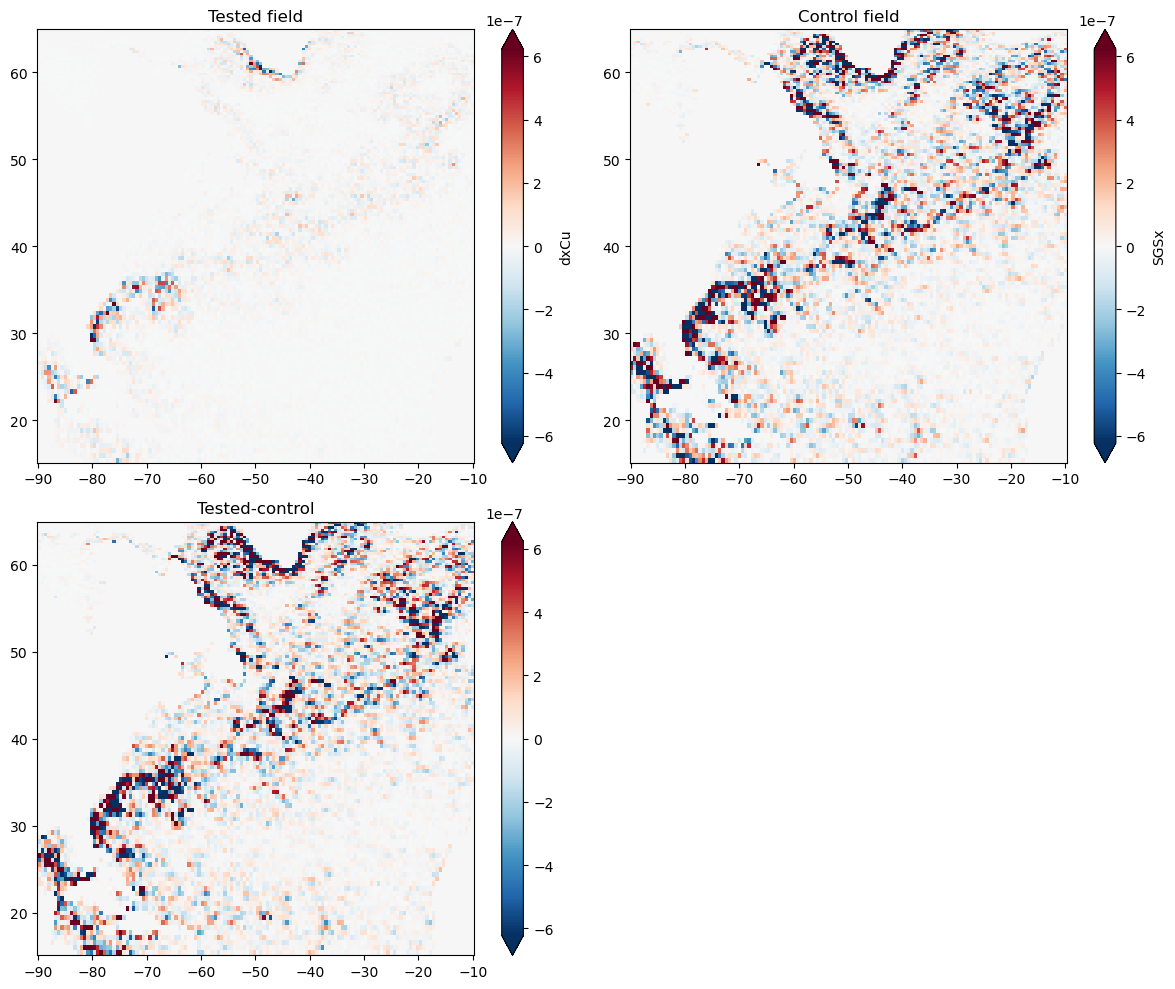

In [43]:
testing_dataset = ds.sample_epoch(time=np.random.randint(6950,8035))
for factor in [6]:
    dataset = testing_dataset[factor]
    sgsx = dataset.data.SGSx
    ann = dataset.state.ANN(ann_Txy, ann_Txx_Tyy, time_revers=False)['ZB20u']
    ann_rev = dataset.state.ANN(ann_Txy, ann_Txx_Tyy, time_revers=True)['ZB20u']
    compare(ann, sgsx)#,selector=lambda x: x)

(0.0, 1.5)

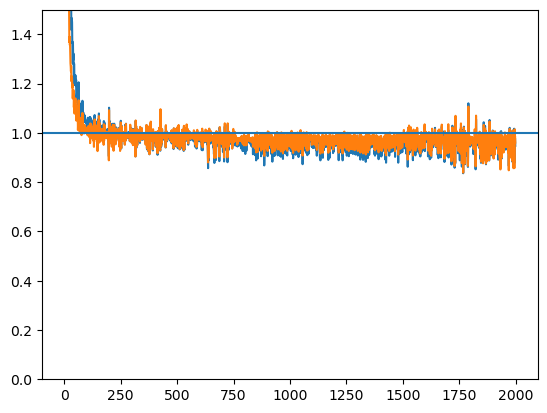

In [27]:
import json
import matplotlib.pyplot as plt

with open('trained_models/ANN_CM26_irrev/log_dict_epoch_2000') as f:
    data = json.load(f)
    
    plt.plot([data[f'epoch-{j}-factor-4']['MSE_train'] for j in range(1,2001)], label='Train')
plt.plot([data[f'epoch-{j}-factor-4']['loss_irrevers'] for j in range(1,2001)], label='Test')
#plt.yscale('log')
plt.axhline(y=1.0)
plt.ylim([0.0,1.5])

# Does irreversible model predict the transfer spectrum?

In [3]:
from helpers.computational_tools import select_LatLon, x_coord, y_coord
import xrft
import warnings
warnings.filterwarnings("ignore")

In [4]:
def compute_isotropic_cospectrum(u_in, v_in, fu_in, fv_in, dx, dy, Lat=(40,60), Lon=(-40,-20), window='hann', 
        nfactor=2, truncate=False, detrend='linear', window_correction=True, compensated=True):
    # Select desired Lon-Lat square
    u = select_LatLon(u_in,Lat,Lon)
    v = select_LatLon(v_in,Lat,Lon)
    fu = select_LatLon(fu_in,Lat,Lon)
    fv = select_LatLon(fv_in,Lat,Lon)

    # mean grid spacing in metres
    dx = select_LatLon(dx,Lat,Lon).mean().values
    dy = select_LatLon(dy,Lat,Lon).mean().values

    # define uniform grid
    x = dx*np.arange(len(u.xh))
    y = dy*np.arange(len(u.yh))
    
#    return dx, dy, x, y, u, v, fu, fv
    
    for variable in [u, v, fu, fv]:
        variable['xh'] = x
        variable['yh'] = y

    Eu = xrft.isotropic_cross_spectrum(u, fu, dim=('xh','yh'), window=window, nfactor=nfactor, 
        truncate=truncate, detrend=detrend, window_correction=window_correction)
    Ev = xrft.isotropic_cross_spectrum(v, fv, dim=('xh','yh'), window=window, nfactor=nfactor, 
        truncate=truncate, detrend=detrend, window_correction=window_correction)

    E = (Eu+Ev)
    E['freq_r'] = E['freq_r']*2*np.pi # because library returns frequencies, but not wavenumbers
    
    if compensated:
        return np.real(E) * E['freq_r']
    else:
        return np.real(E)

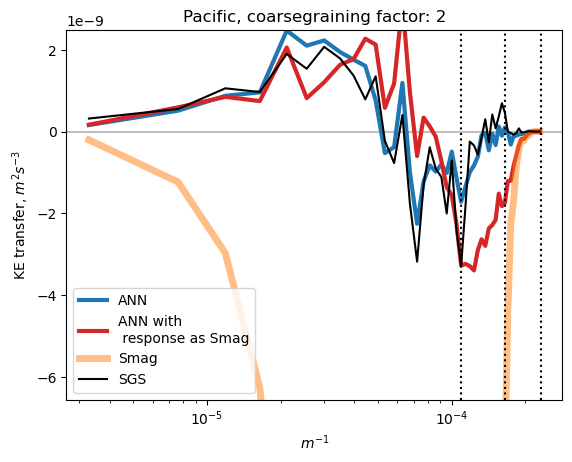

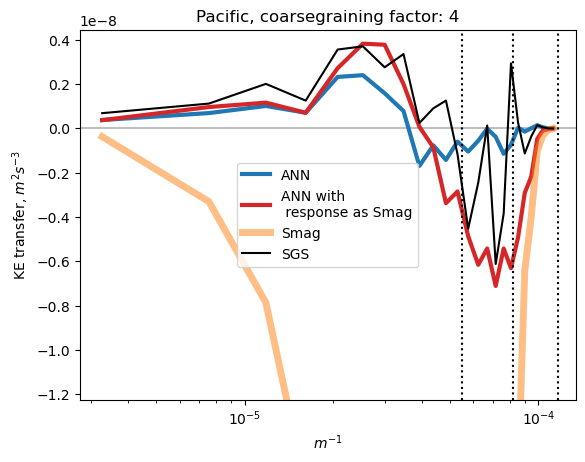

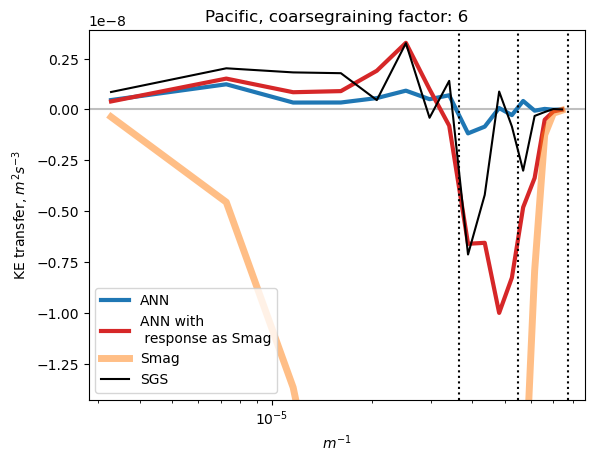

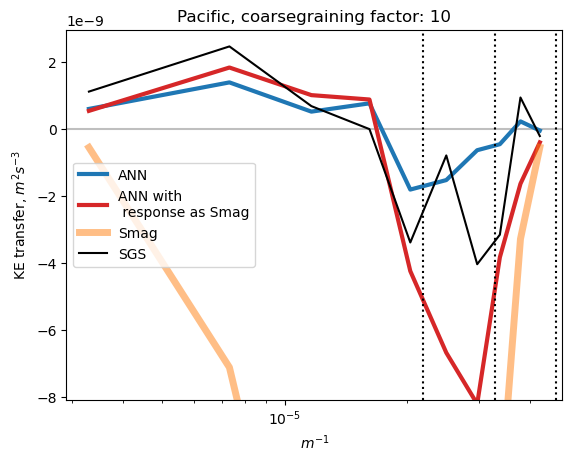

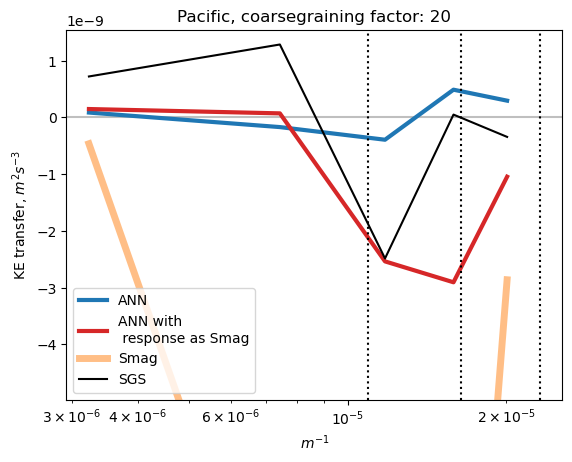

In [23]:
testing_dataset = ds.sample_epoch(time=np.random.randint(6950,8035))
NA = {'Lat': (40,60), 'Lon': (-40,-20)}
Pacific = {'Lat': (20,40), 'Lon': (-200,-180)}
region = Pacific
for factor in [2,4,6,10,20]:
    dataset = testing_dataset[factor]
    
    smag  = dataset.state.Smagorinsky()
    smagx = dataset.grid.interp(smag['smagx'],'X')
    smagy = dataset.grid.interp(smag['smagy'],'Y')

#     ann_Txy = import_ANN('trained_models/ANN_CM26_grid_harmonic/Txy_epoch_500.nc')
#     ann_Txx_Tyy = import_ANN('trained_models/ANN_CM26_grid_harmonic/Txx_Tyy_epoch_500.nc')
#     zb = dataset.state.ANN(ann_Txy, ann_Txx_Tyy)
#     ANNx_grid = dataset.grid.interp(zb['ZB20u'],'X')
#     ANNy_grid = dataset.grid.interp(zb['ZB20v'],'Y')
    
#     ann_Txy = import_ANN('trained_models/ANN_CM26_grid_harmonic_ver2/Txy_epoch_100.nc')
#     ann_Txx_Tyy = import_ANN('trained_models/ANN_CM26_grid_harmonic_ver2/Txx_Tyy_epoch_100.nc')
#     zb = dataset.state.ANN(ann_Txy, ann_Txx_Tyy)
#     ANNx_grid_ver2 = dataset.grid.interp(zb['ZB20u'],'X')
#     ANNy_grid_ver2 = dataset.grid.interp(zb['ZB20v'],'Y')

    ann_Txy = import_ANN('trained_models/ANN_CM26_grid_harmonic_ver3/Txy_epoch_1000.nc')
    ann_Txx_Tyy = import_ANN('trained_models/ANN_CM26_grid_harmonic_ver3/Txx_Tyy_epoch_1000.nc')
    zb = dataset.state.ANN(ann_Txy, ann_Txx_Tyy)
    ANNx_grid_ver3 = dataset.grid.interp(zb['ZB20u'],'X')
    ANNy_grid_ver3 = dataset.grid.interp(zb['ZB20v'],'Y')

    
#     ann_Txy = import_ANN('trained_models/ANN_CM26_irrev/Txy_epoch_2000.nc')
#     ann_Txx_Tyy = import_ANN('trained_models/ANN_CM26_irrev/Txx_Tyy_epoch_2000.nc')
#     zb = dataset.state.ANN(ann_Txy, ann_Txx_Tyy)
#     ANNx_irrev = dataset.grid.interp(zb['ZB20u'],'X')
#     ANNy_irrev = dataset.grid.interp(zb['ZB20v'],'Y')


    ann_Txy = import_ANN('trained_models/ANN_CM26/Txy_epoch_2000.nc')
    ann_Txx_Tyy = import_ANN('trained_models/ANN_CM26/Txx_Tyy_epoch_2000.nc')
    zb = dataset.state.ANN(ann_Txy, ann_Txx_Tyy)
    ANNx = dataset.grid.interp(zb['ZB20u'],'X')
    ANNy = dataset.grid.interp(zb['ZB20v'],'Y')

    u = dataset.grid.interp(dataset.data.u,'X')
    v = dataset.grid.interp(dataset.data.v,'Y')
    dx = dataset.param.dxT
    dy = dataset.param.dyT
    SGSx = dataset.grid.interp(dataset.data.SGSx,'X')
    SGSy = dataset.grid.interp(dataset.data.SGSy,'Y')
    
    kmax = np.pi / select_LatLon(dx, **region).mean()
    
    
    plt.figure()
    plt.axhline(y=0, color='gray', alpha=0.5)
    compute_isotropic_cospectrum(u, v, ANNx, ANNy, dx, dy, **region).plot(lw=3,label='ANN')
#    compute_isotropic_cospectrum(u, v, ANNx_grid, ANNy_grid, dx, dy, **region).plot(lw=3,label='ANN grid-harmonic')
#    compute_isotropic_cospectrum(u, v, ANNx_grid_ver2, ANNy_grid_ver2, dx, dy, **region).plot(lw=3,label='ANN grid-harmonic ver2')
    compute_isotropic_cospectrum(u, v, ANNx_grid_ver3, ANNy_grid_ver3, dx, dy, **region).plot(lw=3,label='ANN with \n response as Smag', color='tab:red')
#    compute_isotropic_cospectrum(u, v, ANNx_irrev, ANNy_irrev, dx, dy, **region).plot(lw=3,label='ANN time-irreversible')
    compute_isotropic_cospectrum(u, v, smagx, smagy, dx, dy, **region).plot(lw=5,label='Smag', alpha=0.5)
    SGS_csp = compute_isotropic_cospectrum(u, v, SGSx, SGSy, dx, dy, **region)
    SGS_csp.plot(label='SGS', color='k')
    plt.ylim([SGS_csp.min()*2, SGS_csp.max()*1.2])
    plt.xscale('log')
    plt.legend()
    plt.xlabel('$m^{-1}$')
    plt.ylabel('KE transfer, $m^2 s^{-3}$')
    
    plt.axvline(x=kmax * 2./3.,color='k',ls=':')
    plt.axvline(x=kmax,color='k',ls=':')
    plt.axvline(x=kmax*np.sqrt(2),color='k',ls=':')
    if region==NA:
        plt.title(f'North Atlantic, coarsegraining factor: {factor}')
    elif region==Pacific:
        plt.title(f'Pacific, coarsegraining factor: {factor}')